# Chapter 8: Cycle GAN: Convert Horses to Zebras




The GAN models we have discussed in the last three chapters are all trying to produce images that are indistinguishable from those in the training set. In this chapter, we'll discuss Cycle GAN, a model in which we can translate a particular feature from one group to another group of images. In particular, you'll train a model that can take in a picture of a horse and convert it into an image of a zebra. You'll also train a model that can convert a human face image without glasses to a face image with glasses. The same model can also convert a face image with glasses to a face image without glasses. 

One feature of Cycle GAN models is that the training set doesn't contain paired images (good luck getting a horse and a zebra to pose in the same position and taking pictures!). Instead, the model uses a cycle consistency loss function to enable the translation of features from one domain to another without paired images. The idea behind the cycle consistency loss is truly ingenious and deserves some highlight here. Let's use the horse/zebra dataset as the example. The Cycle GAN model has two generators: let's call them the horse generator and the zebra generator, respectively. The horse generator takes in a zebra image and converts it to a horse image, while the zebra generator takes in a horse image and converts it to a zebra image. 

To train the model, we'll give a real horse image to the zebra generator to produce a fake zebra. We'll then give the fake zebra image to the horse generator to produce a fake horse image. If both the horse generator and the zebra generator work perfectly, then there is no difference between the original horse image and the fake horse image produced by the horse generator. Therefore, the model minimizes the cycle consistency loss: the difference between the original horse picture and the fake horse picture. The inclusion of the cycle consistency loss is the key innovation in Cycle GANs. The code in this chapter are adapted from two online projects: the Kaggle project by Yashika Jain https://www.kaggle.com/code/yashikajain/eye-glass-removal and a GitHub repository by Aladdin Persson https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/GANs/CycleGAN. 

Start a new cell in ch08.ipynb and execute the following lines of code in it:

In [1]:
import os

os.makedirs("files/ch08", exist_ok=True)

# 1. The Horse and Zebra Dataset
We'll use two datasets in this chapter: the horse and zebra dataset that you can download below https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip and the eye glasses dataset that you used in Chapter 7.

## 1.1 Download the Horse and Zebra Dataset
After downloading the horse and zebra dataset, you should unzip it and place it in the folder /Desktop/ai/files/ch07/ on your computer. It contains four subfolders: trainA, trainB, testA, and testB. 

Next, we'll print out eight images from each folder and plot them in a four by eight matrix: 

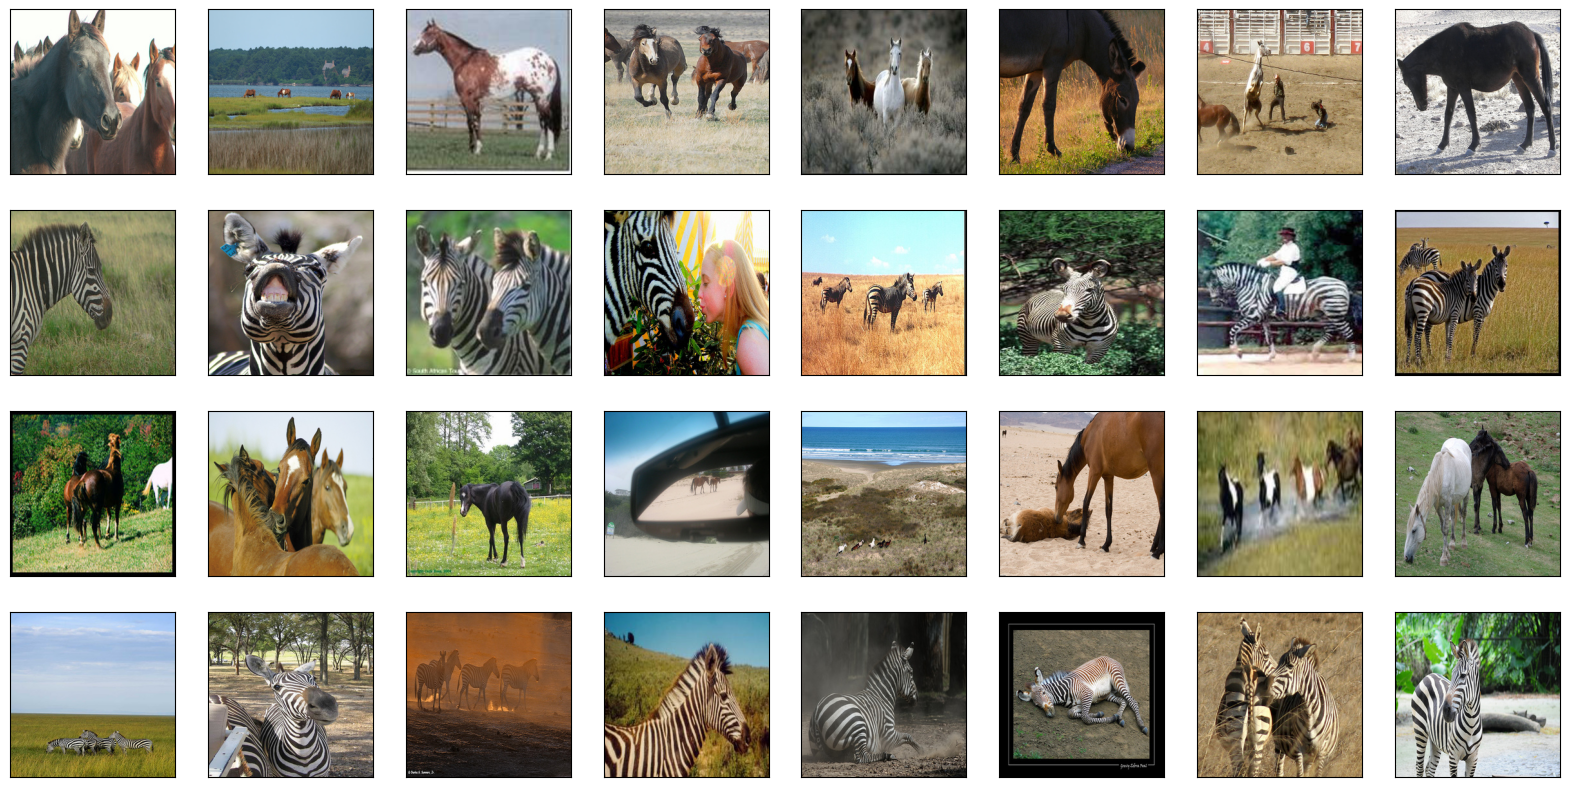

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

trainA="files/ch07/trainA/"
trainB="files/ch07/trainB/"
testA="files/ch07/testA/"
testB="files/ch07/testB/"

trainA_imgs=os.listdir(trainA)
trainB_imgs=os.listdir(trainB) 
testA_imgs=os.listdir(testA)
testB_imgs=os.listdir(testB)

imgs=[]

folders=[trainA,trainB,testA,testB]
files=[trainA_imgs,trainB_imgs,testA_imgs,testB_imgs]

for folder,file in zip(folders,files):
    for j in range(8):
        imgs.append(folder+file[j])

import matplotlib.pyplot as plt
from PIL import Image
plt.figure(figsize=(20,10),dpi=100)
for i in range(32):
    ax = plt.subplot(4, 8, i + 1)
    img=Image.open(f"{imgs[i]}")
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
plt.show()  

Images in folders /trainA and /testA are training and test data sets of horses. Images in folders /trainB and /testB are training and test data sets of zebra. 

We can count how many images in each folder as follows:

In [3]:
print(f"there are {len(trainA_imgs)} images in folder trainA")
print(f"there are {len(trainB_imgs)} images in folder trainB")
print(f"there are {len(testA_imgs)} images in folder testA")
print(f"there are {len(testB_imgs)} images in folder testB")

there are 1067 images in folder trainA
there are 1334 images in folder trainB
there are 120 images in folder testA
there are 140 images in folder testB


We'll use the 1067 horse images and 1334 zebra images as our training dataset in Cycle GAN. 

## 1.2. Transform the Data
We'll generalize the model in the sense that it can be applied to any datasets. In this chapter, we'll apply the model to the horse/zebra dataset as well as the glasses dataset that we have seen in Chapter 7. 

Therefore, we have created a local module *ch08util*. Download the file *ch08util.py* from the book's GitHub repository and place it in the folder /Desktop/ai/utils/ on your computer. In it, we have defined the following *LoadData()* class:

In [4]:
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset
from tqdm import tqdm
from torchvision.utils import save_image

class LoadData(Dataset):
    def __init__(self, root_A, root_B, transform=None):
        super().__init__()
        self.root_A = root_A
        self.root_B = root_B
        self.transform = transform
        self.A_images = os.listdir(root_A)
        self.B_images = os.listdir(root_B)
        self.len_data = max(len(self.A_images),
                            len(self.B_images))
        self.A_len = len(self.A_images)
        self.B_len = len(self.B_images)
    def __len__(self):
        return self.len_data
    def __getitem__(self, index):
        A_img = self.A_images[index % self.A_len]
        B_img = self.B_images[index % self.B_len]
        A_path = os.path.join(self.root_A, A_img)
        B_path = os.path.join(self.root_B, B_img)
        A_img = np.array(Image.open(A_path).convert("RGB"))
        B_img = np.array(Image.open(B_path).convert("RGB"))
        if self.transform:
            augmentations = self.transform(image=B_img,
                                           image0=A_img)
            B_img = augmentations["image"]
            A_img = augmentations["image0"]
        return A_img, B_img 

The class *LoadData()* loads two different types of images from two folders: *root_A* and *root_B*. We'll use it on horse/zebra data (horses are As and zebras are Bs) as well as the glasses data (images with glasses as As and images without glasses as Bs). 

# 2. The Cycle GAN Model
We'll develop a Cycle GAN model to translate type A images to type B images and vice versa. Therefore, there are two generators and two discriminators in the model: generator A will take a real type B image as input and produce a fake type A image. That is, generator A translates a type B photo to a type A photo. Similarly, generator B will take a real type A image and translates it into a fake type B image. 

There are two discriminators as well: discriminator A will take in either a real type A image or a fake type A image and determine if the image is real or fake. Similarly, discriminator B will take in either a real type B image or a fake type B image and determine if the image is real or fake. 

## 2.1. Discriminators in Cycle GAN
Even though the Cycle GAN has two discriminators, they are identical ex ante. That is, we'll create one single *Discriminator()* class and then instantiate the class twice: one instance is discriminator A and the other discriminator B. 

Open the file *ch08util.py* you just downloaded. In it, we have defined the *Discriminator()* class as follows:

In [5]:
import torch.nn as nn
import torch

# determine the device automatically
device = "cuda" if torch.cuda.is_available() else "cpu"
class Block(nn.Module):
    def __init__(self,in_channels,out_channels,stride):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,4,stride,1,
                bias=True,padding_mode="reflect"),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2,inplace=True))
    def forward(self, x):
        return self.conv(x)

class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64,128,256,512]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels,features[0],
                kernel_size=4,stride=2,padding=1,
                padding_mode="reflect"),
            nn.LeakyReLU(0.2, inplace=True))
        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(Block(in_channels, feature, 
                stride=1 if feature == features[-1] else 2))
            in_channels = feature
        layers.append(nn.Conv2d(in_channels,1,kernel_size=4,
                stride=1,padding=1,padding_mode="reflect"))
        self.model = nn.Sequential(*layers)
    def forward(self, x):
        out = self.model(self.initial(x))
        return torch.sigmoid(out)

We then create two instances of the class and call them *disc_A* and *disc_B*, respectively, as follows:

In [6]:
from utils.ch08util import Discriminator

disc_A = Discriminator().to(device)
disc_B = Discriminator().to(device)

Each discriminator takes a three-channel image as the input and the output is a value between 0 and 1 since we have used the sigmoid activation function at the last layer in the *Discriminator()* class. The output can be interpreted as the probability that the image is real. 

## 2.2. Generators in Cycle GAN
Similarly, we'll create one single *Generator()* class and then instantiate the class twice: one instance is generator A and the other generator B. 

Open the file *ch08util.py* you just downloaded. In it, we have defined the *Generator()* class as follows:

In [7]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, 
                 down=True, use_act=True, **kwargs):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 
                      padding_mode="reflect", **kwargs)
            if down
            else nn.ConvTranspose2d(in_channels, 
                                    out_channels, **kwargs),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True) if use_act else nn.Identity())
    def forward(self, x):
        return self.conv(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            ConvBlock(channels,channels,kernel_size=3,padding=1),
            ConvBlock(channels,channels,
                      use_act=False, kernel_size=3, padding=1))
    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, img_channels, num_features=64,
                 num_residuals=9):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(img_channels,num_features,kernel_size=7,
                stride=1,padding=3,padding_mode="reflect",),
            nn.InstanceNorm2d(num_features),
            nn.ReLU(inplace=True))
        self.down_blocks = nn.ModuleList(
            [ConvBlock(num_features,num_features*2,kernel_size=3,
                       stride=2, padding=1),
            ConvBlock(num_features*2,num_features*4,kernel_size=3,
                stride=2,padding=1)])
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(num_features * 4) 
            for _ in range(num_residuals)])
        self.up_blocks = nn.ModuleList(
            [ConvBlock(num_features * 4, num_features * 2,
                    down=False, kernel_size=3, stride=2,
                    padding=1, output_padding=1),
                ConvBlock(num_features * 2, num_features * 1,
                    down=False,kernel_size=3, stride=2,
                    padding=1, output_padding=1)])
        self.last = nn.Conv2d(num_features * 1, img_channels,
            kernel_size=7, stride=1,
            padding=3, padding_mode="reflect")
    def forward(self, x):
        x = self.initial(x)
        for layer in self.down_blocks:
            x = layer(x)
        x = self.res_blocks(x)
        for layer in self.up_blocks:
            x = layer(x)
        return torch.tanh(self.last(x))

We create two instances of the *Generator()* class and call one of them *gen_A* and the other *gen_B*, like so:

In [8]:
from utils.ch08util import Generator

gen_A = Generator(img_channels=3, num_residuals=9).to(device)
gen_B = Generator(img_channels=3, num_residuals=9).to(device)

The *Generator()* class contains nine residual blocks. Each generator takes a real image as the input and produces a fake image as output. We have preprocessed all images so that the pixels values in all images are between -1 and 1. Therefore, we use the *tanh()* activation function in the last layer so all output values are between -1 and 1 from the generators. 

## 2.3. Cycle Consistency Loss
When training the model, we'll use a weighted average of L1 and L2 losses. L1 loss is the mean absolute error while L2 loss is the mean squared error. Therefore, we import the following loss functions: 

In [9]:
l1 = nn.L1Loss()
mse = nn.MSELoss()

In particular, the loss function includes the cycle consistency loss. We'll give a real horse image to the zebra generator to produce a fake zebra. We'll then give the fake zebra image to the horse generator to produce a fake horse image. If both the horse generator and the zebra generator work perfectly, then there is no difference between the original horse image and the fake horse image produced by the horse generator. Therefore, the model minimizes the cycle consistency loss: the difference between the original horse picture and the fake horse picture. The inclusion of the cycle consistency loss is the key innovation in Cycle GANs. 

Similarly, we'll give a real zebra image to the horse generator to produce a fake horse. We'll then give the fake horse image to the zebra generator to produce a fake zebra image. If both the horse generator and the zebra generator work perfectly, there is no difference between the original zebra image and the fake zebra image produced by the zebra generator. 

Later, you'll see the following code in the training process:

```python
fake_A = gen_A(B)
fake_B = gen_B(A)
cycle_B = gen_B(fake_A)
cycle_A = gen_A(fake_B)
cycle_B_loss = l1(B, cycle_B)
cycle_A_loss = l1(A, cycle_A)
```

The cycle A loss and cycle B loss are new additions to the generator's objective function compared to earlier versions of GANs such as DCGANs or conditional GANs. 

We'll use the Adam optimizer for both the discriminators and the generators:

In [10]:
lr = 0.00001
opt_disc = torch.optim.Adam(list(disc_A.parameters()) + 
  list(disc_B.parameters()),lr=lr,betas=(0.5, 0.999))
opt_gen = torch.optim.Adam(list(gen_A.parameters()) + 
  list(gen_B.parameters()),lr=lr,betas=(0.5, 0.999))

# 3. Train the Cycle GAN
Now that we have the training data and Cycle GAN model, we'll apply the model on the horse/zebra dataset and train both the two discriminators and the two generators. After that, we'll discard the discriminators and use the two generators to create fake horse and zebra images. 

## 3.1. Plot Ouputs Periodically
We'll create a function to test what the real images look like and what the fake images generated by G look like so that we can the fake ones with the real ones. The function, which is in the file *ch08util.py*, is defined as follows:

In [11]:
def test(i,A,B,fake_A,fake_B):
    save_image(A*0.5+0.5,f"files/ch08/A{i}.png")
    save_image(B*0.5+0.5,f"files/ch08/B{i}.png")
    save_image(fake_A*0.5+0.5,f"files/ch08/fakeA{i}.png")
    save_image(fake_B*0.5+0.5,f"files/ch08/fakeB{i}.png")  

We save four images after every 100 batches of training. We save real images of type A and type B, as well as the fake images of type A and type B so we can periodically check the fake images from the generators and compare them with the real images. 

## 3.2. Train the Cycle GAN Model
We first define a *train_epoch()* function as follows in the file *ch08util.py*:

In [12]:
def train_epoch(disc_A, disc_B, gen_A, gen_B, loader, opt_disc,
        opt_gen, l1, mse, d_scaler, g_scaler,cycle_lambda,device):
    loop = tqdm(loader, leave=True)
    for i, (A,B) in enumerate(loop):
        A=A.to(device)
        B=B.to(device)
        # Train Discriminators A and B
        with torch.cuda.amp.autocast():
            fake_A = gen_A(B)
            D_A_real = disc_A(A)
            D_A_fake = disc_A(fake_A.detach())
            D_A_real_loss = mse(D_A_real, 
                                torch.ones_like(D_A_real))
            D_A_fake_loss = mse(D_A_fake,
                                torch.zeros_like(D_A_fake))
            D_A_loss = D_A_real_loss + D_A_fake_loss
            fake_B = gen_B(A)
            D_B_real = disc_B(B)
            D_B_fake = disc_B(fake_B.detach())
            D_B_real_loss = mse(D_B_real,
                                torch.ones_like(D_B_real))
            D_B_fake_loss = mse(D_B_fake,
                                torch.zeros_like(D_B_fake))
            D_B_loss = D_B_real_loss + D_B_fake_loss
            # Average loss of the two discriminators
            D_loss = (D_A_loss + D_B_loss) / 2
        opt_disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()
        # Train the two generators 
        with torch.cuda.amp.autocast():
            D_A_fake = disc_A(fake_A)
            D_B_fake = disc_B(fake_B)
            loss_G_A = mse(D_A_fake, torch.ones_like(D_A_fake))
            loss_G_B = mse(D_B_fake, torch.ones_like(D_B_fake))
            # NEW in Cycle GANs: cycle loss
            cycle_B = gen_B(fake_A)
            cycle_A = gen_A(fake_B)
            cycle_B_loss = l1(B, cycle_B)
            cycle_A_loss = l1(A, cycle_A)
            # Total generator loss
            G_loss=(loss_G_A+loss_G_B+cycle_A_loss*cycle_lambda
                +cycle_B_loss*cycle_lambda)
        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()
        if i % 100 == 0:
            test(i,A,B,fake_A,fake_B)           
        loop.set_postfix(D_loss=D_loss.item(),G_loss=G_loss.item())

We set some hyperparameters as follows:

In [13]:
import torch.nn as nn
import torch
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision.utils import save_image

device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 1
cycle_lambda = 10
epochs = 10

We then create a data loader to prepare for the actual training, as follows: 

In [14]:
from utils.ch08util import LoadData, train_epoch
from torch.utils.data import DataLoader
from tqdm import tqdm
import albumentations 
from albumentations.pytorch import ToTensorV2

transforms = albumentations.Compose(
    [albumentations.Resize(width=256, height=256),
        albumentations.HorizontalFlip(p=0.5),
        albumentations.Normalize(mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5],max_pixel_value=255),
        ToTensorV2()],
    additional_targets={"image0": "image"}) 

dataset = LoadData(root_A="files/ch08/trainA",
    root_B="files/ch08/trainB",transform=transforms)
loader=DataLoader(dataset,batch_size=batch_size,
    shuffle=True, pin_memory=True)

## 3.3. Start Training
Now that we have everything ready, we'll start the training loop:

In [15]:
g_scaler = torch.cuda.amp.GradScaler()
d_scaler = torch.cuda.amp.GradScaler()

for epoch in range(epochs):
    train_epoch(disc_A, disc_B, gen_A, gen_B, loader, opt_disc,
    opt_gen, l1, mse, d_scaler, g_scaler, cycle_lambda, device)
# save the zebra generator
torch.save(gen_B.state_dict(), "files/ch08/gen_zebra.pth")

Depending on your computer, the above training takes several hours to a couple of days. If you don't have the computing resources to train the model, download the pretrained model from my website https://gattonweb.uky.edu/faculty/lium/ml/gen_zebra.zip. Unzip the file and place the file *gen_zebra.pth* in the folder /Desktop/ai/files/ch08/ on your computer. You'll be able to convert horses to zebras in the next section. 

# 4. Use the Trained Cycle GAN Model
The trained Cycle GAN model can convert zebras to horses and horses to zebras. However, the translation quality is not very good when the model converts zebras to horses. Therefore, we'll focus only on converting horses to zebras. 

## 4.1. Test the Trained Zebra Generator
We'll use the trained model to first convert all horses in the test set to zebras, as follows: 

In [16]:
testset = LoadData(root_A="files/ch08/testA",
    root_B="files/ch08/testB",transform=transforms)
testloader=DataLoader(testset,batch_size=batch_size,
    shuffle=True, pin_memory=True)

sd=torch.load("files/ch08/gen_zebra.pth")
gen_B.load_state_dict(sd)
gen_B.eval()

i=1
for zebra, horse in testloader:
    fake_zebra=gen_B(horse)
    save_image(fake_zebra*0.5+0.5,f"files/ch08/fakeZebra{i}.png")
    save_image(horse*0.5+0.5,f"files/ch08/horse{i}.png")
    i=i+1

Now if you go to the folder /Desktop/ai/files/ch08/, you'll see about 120 images of original horse pictures, as well as 120 fake zebra images. Some of them look really like zebras!

## 4.2. Display the Results
You can also convert all horses in the folder /trainA/ to fake zebras. I selected six fake zebras and put the original horse pictures and the fake zebra pictures into the following subplots:

<img src="https://gattonweb.uky.edu/faculty/lium/ml/horseZebra.jpg" />   

There are six pair of pictures above. In each pair, the image on the left is the original horse picture and the image on the right is the fake zebra image generated by the trained Cycle GAN model. 

# 5. Apply the Cycle GAN on Glasses Images
The Cycle GAN model we created above can be applied to any training dataset with two groups of images. We can also apply the model to the eye glasses dataset we downloaded in Chapter 7. We'll train the model to remove the eye glasses on face images with glasses. The model can also add eye glasses to images without glasses. 

## 5.1. Use the Eye Glasses Dataset
We'll change the training dataset, like this:

In [17]:
dataset = LoadData(
    root_A="files/ch07/data/G",
    root_B="files/ch07/data/NoG",
    transform=transforms)
loader=DataLoader(dataset,batch_size=batch_size,
    shuffle=True, pin_memory=True)

We define type A images as human face pictures with eye glasses, and type B images are the ones without eye glasses. 

We also need to redefine the two discriminators, the two generators, and the optimizers:

In [18]:
disc_A = Discriminator().to(device)
disc_B = Discriminator().to(device)

gen_A = Generator(img_channels=3, num_residuals=9).to(device)
gen_B = Generator(img_channels=3, num_residuals=9).to(device)

lr = 0.00001
opt_disc = torch.optim.Adam(list(disc_A.parameters()) + 
  list(disc_B.parameters()),lr=lr,betas=(0.5, 0.999))
opt_gen = torch.optim.Adam(list(gen_A.parameters()) + 
  list(gen_B.parameters()),lr=lr,betas=(0.5, 0.999))

We can now train the Cycle GAN model again: 

In [19]:
for epoch in range(epochs):
    train_epoch(disc_A, disc_B, gen_A, gen_B, loader, opt_disc,
    opt_gen, l1, mse, d_scaler, g_scaler, cycle_lambda, device)
# save the generator to remove glasses
torch.save(gen_B.state_dict(), "files/ch08/remove.pth")
# save the generator to add glasses
torch.save(gen_A.state_dict(), "files/ch08/add.pth")

Depending on your computer, the above training takes several hours to a couple of days. If you don't have the computing resources to train the model, download the pretrained model from my website https://gattonweb.uky.edu/faculty/lium/ml/add.zip and https://gattonweb.uky.edu/faculty/lium/ml/remove.zip. Unzip the files and place them in the folder /Desktop/ai/files/ch08/ on your computer. You'll be able to add or remove eye glasses by using these two pretrained generators. 

## 5.2. Test the Trained Generators
We'll use the trained model to first add eye glasses to all images without glasses and to remove glasses from images with glasses, as follows: 

In [20]:
sd_A=torch.load("files/ch08/add.pth")
gen_A.load_state_dict(sd_A)
gen_A.eval()
sd_B=torch.load("files/ch08/remove.pth")
gen_B.load_state_dict(sd_B)
gen_B.eval()
i=1
for nog,g in loader:
    fake_nog=gen_B(g)
    save_image(fake_nog*0.5+0.5,f"files/ch08/fakenog{i}.png")
    save_image(g*0.5+0.5,f"files/ch08/g{i}.png")
    fake_g=gen_A(nog)
    save_image(fake_g*0.5+0.5,f"files/ch08/fakeg{i}.png")
    save_image(nog*0.5+0.5,f"files/ch08/nog{i}.png")    
    i=i+1

If you go to the folder /Desktop/ai/files/ch08/, you'll see that human face images with glasses are converted to images without glasses. You'll also see that human face images without glasses are converted to images with glasses. 

## 5.3. Display the Results
I selected 24 pairs of images with glasses and results produced by the trained generator. The results are displayed below:

<img src="https://gattonweb.uky.edu/faculty/lium/ml/removeglasses.jpg" />   

For each pair of images, the one on the left is the original image and the one on the right is the result after the glasses being removed by the pretrained generator. The results look very convincing!

I also selected images without glasses and use the trained model to add glasses. The results are displayed below:

<img src="https://gattonweb.uky.edu/faculty/lium/ml/addglasses.jpg" />   

As you can see, the images with glasses are actually generated by the trained model, but they look like real photos. 